# Aplicación de clasificación de perros

En este proyecto implementarás una CNN para clasificar perros utilizando Transfer Learning. Este es el primer proyecto completo que haremos, y, por lo tanto, será más retador. Asegúrate de completar los otros cuadernos antes. Aprenderemos a construir un pipeline que luego puede ser usado una página o aplicación para procesar imágenes reales dadas por un usuario. La idea es que, dada la imagen de un perro, identifique el estimado de que sea una raza. Si la imagen es de un humano, dirá a qué raza de perro se parece.


![perro](https://github.com/osanseviero/Dog-Breed-Classifier/raw/master/images/sample_dog_output.png "Objetivo")

Además de explorar modelos de CNN que son estado del arte para clasificación, también tendrás que tomar decisiones del UX. El objetivo es entender los retos que hay cuando se quieren juntar varios modelos diseñados para diferentes tareas al procesar data. Cada modelo tiene sus fortalezas y sus debilidades, y muchas veces las aplicaciones de la vida real no podrán dar respuestas perfectas. Hay 7 secciones en el proyecto. 

Antes de comenzar, desde tu ambiente (curso-dl), corre las siguientes líneas

* ```conda update --all```
* ```conda install scikit-learn```
* ```conda install opencv```
* ```conda install tqdm```
* ```conda install pillow```

Después, necesitamos descargar dos datasets.
* [Dataset Perro](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).Después de descomprimirlo, ponlo en la carpeta /dogImages. 
* [Dataset humanos](http://vis-www.cs.umass.edu/lfw/lfw.tgz). Después de descomprimirlo, ponlo en la carpeta /lfw
* Y descarga los [features de VGG16](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz). Ponlo en la carpeta /bottleneck_features.

## Paso 0. Importar Datasets

### Dataset de perros
En la siguiente celda, importamos un dataset con imágenes de perros. Cargamos los archivos con scikit-learn y cargamos:

* train_files, valid_files, test_files - arreglos con las direcciones al entrenamiento, validación y testing

* train_targets, valid_targets, test_targets - arreglos con los labels (y) ya habiendo hecho el one-hot encoding

* dog_names - lista de las razas de perros para poder traducir los labels


In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# función para cargar dataset dado un path
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# cargamos training, testing y validation dataset. Ya vienen separados
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# Cargamos los nombres de los perros según el nombre de las carpetas.
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# Imprimimos algunos datos del dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Dataset de humanos
En la siguiente celda, importamos un dataset con imágenes de humanos. Aquí no tenemos training ni testing, dado que no es parte del problema de clasificar perros.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


## Paso 1. Detección de humanos

Para detectar las caras de personas en las imágenes, utilizaremos algo que ya está implementado en OpenCV llamado Haar feature-based cascade classifier. OpenCV viene con varios detectores de cara pre-entrenados que ya están guardados como XML en GitHub. En el directorio llamado haarcascades puedes encontrar uno de estos detectores. 

Aquí te muestro un ejemplo de cómo usarlo:

Number of faces detected: 2


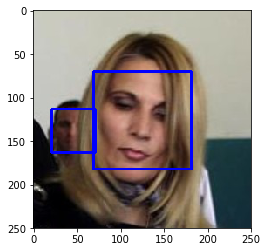

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# conseguimos el detector de cara pre-entrenado
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# cargamos una imagen de humano en BGR. Si sólo encuentra una cara, 
# puedes cambiar este número (se cargan aleatoriamente)
img = cv2.imread(human_files[123])

# convertimos la imagen BGR a grayscale. No nos importa el color
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# encontramos las caras en la imagen con el método detectMultiScale
faces = face_cascade.detectMultiScale(gray)
print('Number of faces detected:', len(faces))

# conseguimos bounding box para cada cara encontrada (sólo tenemos una en este problema)
for (x,y,w,h) in faces:
    # agregamos un bounding box encima de la imagen original
    cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
    
# convertimos imagen BGR a RGB para poder graficarla
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Mostramos la imagen
plt.imshow(cv_rgb)
plt.show()


Antes de utilizar cualquier detector de cara, es buena práctica convertir la imagen a escala de grises. El método ```detectMultiScale``` ejecuta el clasificador en face_cascade y recibe esa imagen en escala de grises como parámetros.

faces, el resultado de la función, es un np.array con las caras detectadas, donde cada fila corresponde a una cara. Cada cara es un arreglo con 4 entradas que especifican cómo es el bounding box. Los primeros dos elementos (x y y) son las posiciones de las esquinas de la izquierda. Los otros dos elementos (w y h) son el width y height del bounding box.

### Implementando un detector de caras
Podemos seguir este proceso para escribir una función que devuelve True si hay una cara de humano y False sino. La función recibe como parámetro el path del archivo.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### TODO: Revisa qué tan bueno es este detector.
Cambia la siguiente celda para ver el performance del detector que acabamos de implementar. 
* ¿Qué porcentaje de las primeras 100 imágenes de humanos tienen una cara detectada?
* ¿Qué porcentaje de las primeras 100 imágenes de perros tienen una cara detectada?

Idealmente, tendríamos 100% para las imágenes de humanos y 0% para las imágenes de perros. El algoritmo no es perfecto, pero tiene un buen desempeño (aceptable). Extraemos los paths de las primeras 100 imágenes y las guardamos en np.arrays. Responde estas preguntas.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# No modifiques el código de arriba

## TODO: Prueba el desempeño del detector con los dos arreglos de arriba
human_count = 0
for human_img in human_files_short:
    if face_detector(human_img):
        human_count = human_count + 1
        
dog_count = 0
for dog_img in dog_files_short:
    if face_detector(dog_img):
        dog_count = dog_count + 1
print(str(human_count) + "% of the humans were detected as humans!")
print(str(dog_count) + "% of the dogs were detected as humans")

98% of the humans were detected as humans!
11% of the dogs were detected as humans


**Pregunta 2.** Este proceso algoritmico necesita comunicar al usuario que sólo se aceptan imágenes de humanos donde se tenga una clara vista de la cara (sino, los usuarios se podrían frustar). En tu opinión, ¿es una expectativa razonable para imponer en el usuario? ¿Se te ocurre algún método para detectar humanos en imágenes qe no necesiten tener la cara presentada propiamente?


## Paso 2. Detección de Perros
En esta sección, utilizaremos un modelo pre-entrenado de [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) para detectar perros. La primera línea de código descarga ResNet-50, con pesos que han sido entrenados para [ImageNet](http://www.image-net.org/), el dataset largo y popular de clasificación de imágenes. ImageNet tiene más de 10 millones de URLs, cada uno linkeando a una imagen conteniendo un objeto de una de 1000 categorías. Dada una imagen, este modelo pre-entrenado devuelve su predicción de las categorías de ImageNet.

In [6]:
from keras.applications.resnet50 import ResNet50

# definimos el modelo ResNet50
ResNet50_model = ResNet50(weights='imagenet')

### Preprocesamos la información

Las redes neuronales convolucionales en Keras requieren un arreglo de 4 dimensiones de input (tensor 4D) como entrada, con un tamaño de (samples, rows, columns, channels). La siguiente función, path_to_tensor, convierte el path de una imagen de color a un tensor 4D que podremos dar a una CNN en Keras. Esta función primero carga la imagen y la convierte en un cuadrado de 224x224. Después, la imagen se convierte en un arreglo que se ajusta a 4D. Como trabajamos con imágenes de color, tenemos 3 canales. Como sólo procesamos una imagen, el tensor siempre tendrá el tamaño (1, 224, 224, 3).

En el caso de la función paths_to_tensor, se recibe un arreglo con los paths y se regresa un tensor 4D con la forma (samples, 224, 224, 3).

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # carga la imagen RGB
    img = image.load_img(img_path, target_size=(224, 224))
    
    # convierte la imagen a un tensor 3D de (224, 224, 3)
    x = image.img_to_array(img)
    
    # convierte tensor 3D a 4D con forma (1, 224, 224, 3)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Haciendo predicciones con ResNet

Ahora que tenemos los tensores en 4D, sólo necesitamos hacer un poco de preprocesamiento adicional.
* Convertir RGB a BGR reordenando los canales
* Paso de normalización - se resta el pixel promedio (de todas las imágenes de ImageNet) de cada pixel.

Estos dos pasos ya están implementados en la función preprocess_input de Keras.

Con las imágenes en el formato correcto, podemos darlas ResNet-50 y extraer las predicciones. Esto lo logramos con el método predict, el cuál devuelve un arreglo donde cada entrada es la probabilidad predecida de que una imagen pertenezca a una clase de ImageNet. Utilizamos la función argmax del vector de probabilidades para obtener el número que corresponde al elemento predecido.

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # regresa vector con predicciones de la imagen
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Detector de Perros 

Revisa el [diccionario de ImageNet](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). No hay una categoría de perros como tal, pero las categorías 151 a 268 corresponden a razas de perros, de Chihuahua a Mexican Hairless. Para detectar si es un perro, sólo necesitamos ver que el valor devuelto por la predicción esté en ese rango.

In [9]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

### TODO Revisa qué tan bueno es este detector 

**Pregunta 3.** Al igual que antes, responde estas preguntas
* ¿Qué porcentaje de las imágenes de humanos tienen un perro detectado?
* ¿Qué porcentaje de las imágenes de perros tienen un perro detectado?

In [10]:
### TODO: Revisa la precisión utilizando human_files_short y dog_files_short

human_count = 0
for human_img in human_files_short:
    if dog_detector(human_img):
        human_count = human_count + 1
        
dog_count = 0
for dog_img in dog_files_short:
    if dog_detector(dog_img):
        dog_count = dog_count + 1
        
print(str(human_count) + "% of the humans were detected as dogs")
print(str(dog_count) + "% of the dogs were detected as dogs!")

1% of the humans were detected as dogs
100% of the dogs were detected as dogs!


## Paso 3. Crea una CNN que clasifique razas de perros (desde 0)

Ahora que tenemos funciones para detectar humanos y perros, vamos a trabajar en predecir la raza de las imágenes. En este paso, crearás una CNN que los clasifique. Deberás crear tu propia CNN (no uses transfer learning) y tu objetivo es un test accuracy de por lo menos...1%. Más adelante utilizarás otra técnica para hacerlo mucho mejor.

¡No agregues muchas capas! Mientras más parámetros haya, más de tardará el entrenamiento, por lo que es más probable que necesites un GPU. Por suerte, Keras te da un estimado de cuánto tiempo se tarda por cada epoch. Puedes determinar el tiempo de entrenamiento a partir de eso. 

El reto de clasificar razas de perros es extremadamente difícil. Incluso los humanos tienen dificultad. Por ejemplo, entre Brittany y un Welsh Springer Spaniel

![welsh springer spaniel](https://github.com/osanseviero/Dog-Breed-Classifier/raw/04f4caabcdc4fe0f17ab3c94caf1fc07a562f1fc/images/Welsh_springer_spaniel_08203.jpg "Welsh Springer Spaniel")
![britanny](https://github.com/osanseviero/Dog-Breed-Classifier/raw/04f4caabcdc4fe0f17ab3c94caf1fc07a562f1fc/images/Brittany_02625.jpg "Brittany")

No sólo pasa que hay razas similares, sino que una raza puede ser muy diferente, como los labradores (pueden ser crema, chocolate o negros). Siendo 133 clases, si predecimos aleatoriamente, tendríamos menos de 1% de precisión.

### Pre Procesamos los datos
Reescalamos las imágenes

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:18<00:00, 46.10it/s]


### TODO: Implementa arquitectura CNN.
Utiliza una arquitectura que tú quieras. Ya importamos algunos módulos, pero siéntete libre de importar lo que necesites. 

Una arquitectura de sugerencia, si te pierdes. Al utilizar model.summary() al final, debería desplegar el siguiente resultado. (Nota, el tamaño es 224,224, 3)
!["Texto"](https://github.com/osanseviero/Dog-Breed-Classifier/raw/04f4caabcdc4fe0f17ab3c94caf1fc07a562f1fc/images/sample_cnn.png)

In [22]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential


model = Sequential()
# TODO: Define arquitectura
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 64)                0         
__________

**Pregunta 4**. Explica detalladamente la lógica para el orden de las capas

### Compilamos modelo

In [23]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### TODO: Entrena el modelo

In [25]:
from keras.callbacks import ModelCheckpoint  

### TODO: especiifca el número de epochs.

epochs = 1

### No modifiques el siguiente código

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/1
6660/6680 [============================>.] - ETA: 1s - loss: 4.8824 - acc: 0.0102
Epoch 00001: val_loss improved from inf to 4.86741, saving model to saved_models/weights.best.from_scratch.hdf5


OSError: Unable to create file (unable to open file: name = 'saved_models/weights.best.from_scratch.hdf5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

### Cargamos el modelo con menor validation loss

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Hacemos testing del modelo

In [ ]:
# Conseguimos el índice del label de cada uno
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)